# Convolutional Neural Networks (LeNet)

## LeNet

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class Reshape(nn.Module):
    def forward(self,X):
        return X.reshape(-1,1,28,28)

In [3]:
net = nn.Sequential(
    Reshape(),
    nn.Conv2d(1,6,kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6,16,kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84,10),
)
net

Sequential(
  (0): Reshape()
  (1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Sigmoid()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=400, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(f"{layer.__class__.__name__:10}", 'output shape:', X.shape)

Reshape    output shape: torch.Size([1, 1, 28, 28])
Conv2d     output shape: torch.Size([1, 6, 28, 28])
Sigmoid    output shape: torch.Size([1, 6, 28, 28])
AvgPool2d  output shape: torch.Size([1, 6, 14, 14])
Conv2d     output shape: torch.Size([1, 16, 10, 10])
Sigmoid    output shape: torch.Size([1, 16, 10, 10])
AvgPool2d  output shape: torch.Size([1, 16, 5, 5])
Flatten    output shape: torch.Size([1, 400])
Linear     output shape: torch.Size([1, 120])
Sigmoid    output shape: torch.Size([1, 120])
Linear     output shape: torch.Size([1, 84])
Sigmoid    output shape: torch.Size([1, 84])
Linear     output shape: torch.Size([1, 10])


In [20]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

## Training

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [25]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()

        for i, (X,y) in enumerate(train_iter):
            optimizer.zero_grad()
            X,y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])

            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]

            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')



loss 0.469, train acc 0.823, test acc 0.780
7.0 examples/sec on cuda:0


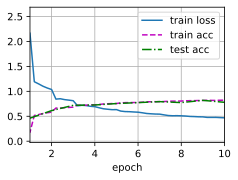

In [25]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [44]:
net2 = nn.Sequential(
    Reshape(),
    nn.LazyConv2d(32, kernel_size=3,padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.LazyConv2d(64, kernel_size=3),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.LazyConv2d(128,kernel_size=3),
    nn.ReLU(),
    nn.Flatten(),
    nn.LazyLinear(400),
    nn.ReLU(),
    nn.LazyLinear(200),
    nn.ReLU(),
    nn.LazyLinear(100),
    nn.ReLU(),
    nn.LazyLinear(10),
)

In [45]:
X = torch.rand((1,1,28,28))
for layer in net2:
    X = layer(X)
    print(f"{layer.__class__.__name__:10}", 'output shape:', X.shape)

Reshape    output shape: torch.Size([1, 1, 28, 28])
Conv2d     output shape: torch.Size([1, 32, 30, 30])
ReLU       output shape: torch.Size([1, 32, 30, 30])
AvgPool2d  output shape: torch.Size([1, 32, 15, 15])
Conv2d     output shape: torch.Size([1, 64, 13, 13])
ReLU       output shape: torch.Size([1, 64, 13, 13])
AvgPool2d  output shape: torch.Size([1, 64, 6, 6])
Conv2d     output shape: torch.Size([1, 128, 4, 4])
ReLU       output shape: torch.Size([1, 128, 4, 4])
Flatten    output shape: torch.Size([1, 2048])
Linear     output shape: torch.Size([1, 400])
ReLU       output shape: torch.Size([1, 400])
Linear     output shape: torch.Size([1, 200])
ReLU       output shape: torch.Size([1, 200])
Linear     output shape: torch.Size([1, 100])
ReLU       output shape: torch.Size([1, 100])
Linear     output shape: torch.Size([1, 10])


loss 0.303, train acc 0.887, test acc 0.868
7.0 examples/sec on cuda:0


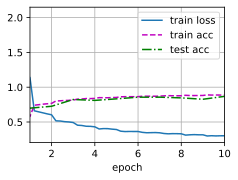

In [47]:
lr, num_epochs = 1e-1, 10
train_ch6(net2, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [21]:
net3 = nn.Sequential(
    Reshape(),
    nn.LazyConv2d(64, kernel_size=3,padding=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.LazyConv2d(128, kernel_size=3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.LazyConv2d(256,kernel_size=3),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Flatten(),
    nn.LazyLinear(2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.LazyLinear(512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.LazyLinear(128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.LazyLinear(10),
)

In [22]:
X = torch.rand((3,1,28,28))
for layer in net3:
    X = layer(X)
    print(f"{layer.__class__.__name__:10}", 'output shape:', X.shape)

Reshape    output shape: torch.Size([3, 1, 28, 28])
Conv2d     output shape: torch.Size([3, 64, 30, 30])
BatchNorm2d output shape: torch.Size([3, 64, 30, 30])
ReLU       output shape: torch.Size([3, 64, 30, 30])
AvgPool2d  output shape: torch.Size([3, 64, 15, 15])
Conv2d     output shape: torch.Size([3, 128, 13, 13])
BatchNorm2d output shape: torch.Size([3, 128, 13, 13])
ReLU       output shape: torch.Size([3, 128, 13, 13])
AvgPool2d  output shape: torch.Size([3, 128, 6, 6])
Conv2d     output shape: torch.Size([3, 256, 4, 4])
BatchNorm2d output shape: torch.Size([3, 256, 4, 4])
ReLU       output shape: torch.Size([3, 256, 4, 4])
Flatten    output shape: torch.Size([3, 4096])
Linear     output shape: torch.Size([3, 2048])
BatchNorm1d output shape: torch.Size([3, 2048])
ReLU       output shape: torch.Size([3, 2048])
Linear     output shape: torch.Size([3, 512])
BatchNorm1d output shape: torch.Size([3, 512])
ReLU       output shape: torch.Size([3, 512])
Linear     output shape: torch.Size

loss 0.189, train acc 0.938, test acc 0.914
0.9 examples/sec on cuda:0


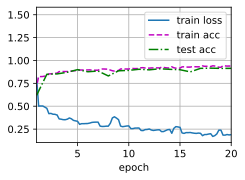

In [26]:
lr, num_epochs = 3e-1, 20
train_ch6(net3, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())